This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from flight_querying import query_flights
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up and retrieve the data from the database.
db_connect = query_flights()

In [2]:
# Make the data dictionary holder
data_dict = {
    "Time Delta": [],
    "SOC Delta": [],
    "SOH": [],
    "Activity": [],
    "Average Power": [],
    "Id": [],
    "Unique Data Identifier": [],
    "temperature": [],
    "Visibility": [],
    "Wind Speed": []
}

# Create a increasing int variable to keep track of the Unique Data Identifier
unique_identifier = 0

In [3]:
def data_parser(parsing_dataframe):

    global unique_identifier

    # Get the current exercise
    current_exercise = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('activity')]
    id = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('id')]
    max_soc, min_soc = 0, 101
    power_list = []
    soh_list = []
    min_time, max_time = 100, 0

    # iterate over all the rows
    for index, row in parsing_dataframe.iterrows():

        # Get the data needed from the rows. Append the power
        new_exercise = row["activity"]
        soc = row["soc"]
        power_list.append(row["power"])
        soh_list.append(round(row["soh"]))
        time = row["time"]
        outside_temp = row["temperature"]
        visibility = row["visibility"]
        wind_speed = row["wind_speed"]

        # If the exercise changes or if the rows end.
        if current_exercise != new_exercise or index == len(parsing_dataframe) - 1:

            # Set the values 
            data_dict["Time Delta"].append(round(max_time - min_time, 2))
            data_dict["SOC Delta"].append(max_soc - min_soc)
            data_dict["Activity"].append(current_exercise)
            data_dict["Average Power"].append(round(sum(power_list)/len(power_list), 2))
            data_dict["SOH"].append(min(soh_list))
            data_dict["temperature"].append(outside_temp)
            data_dict["Visibility"].append(visibility)
            data_dict["Wind Speed"].append(wind_speed)
            data_dict["Id"].append(id)
            data_dict["Unique Data Identifier"].append(unique_identifier)
            unique_identifier = unique_identifier + 1

            # Reset all the values
            max_soc, min_soc = soc, soc
            power_list.clear()
            soh_list.clear()
            max_time, min_time = time, time
        
        # SOC
        if soc >= max_soc:
            max_soc = soc
        if soc <= min_soc:
            min_soc = soc

        # TIME
        if time >= max_time:
            max_time = time
        if time <= min_time:
            min_time = time
        
        # Change current exercise
        current_exercise = new_exercise


In [4]:
# # # Flight IDs to include
# # # query the list of flight ids excluding these six which are already labelled
# # flight_ids = db_connect.get_flight_ids()
# # flight_ids = flight_ids['id'].to_list()
# # ids_avoid = [5190, 5192, 5109]

# # # remove the manually_labelled_ids from the list 
# # flight_ids = [id for id in flight_ids if id not in ids_avoid]
# # print(flight_ids)

# # Flight IDs to include
# flight_ids = [4620, 4929, 4940, 5019, 5021, 5034]

# # Fetch data for specified flight IDs
# # Remove NA values from each dataframe in the list and put it through the data parser
# for ids in flight_ids:
#     frame = db_connect.connect_flight_for_ml_data_prescription(ids)
#     frame = frame[frame["activity"] != "NA"].reset_index()
#     data_parser(frame)

# # Concatenate data frames and shuffle the data
# # all_data = pd.concat(data_frames, axis=0).sample(frac=1, random_state=42)
# all_data = pd.DataFrame(data_dict)

In [5]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [6]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [7]:
all_data.head()

,Unnamed: 0,Time Delta,SOC Delta,SOH,Activity,Average Power,Id,Unique Data Identifier,temperature,Visibility,Wind Speed
0,0,7.88,3.0,83,takeoff,57.27,5367,0,41.0,9.0,9
1,1,2.44,10.5,83,climb,48.63,5367,1,42.8,9.0,8
2,2,0.00,0.0,83,cruise,49.78,5367,2,42.8,9.0,8
3,3,0.00,0.0,83,climb,49.72,5367,3,41.0,9.0,9
4,4,0.00,0.0,83,cruise,49.64,5367,4,42.8,9.0,8


In [8]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 1209 
 Length train_y = 519


One-Hot-Encoding of the Operations columns

In [9]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['Unique Data Identifier'] = df['Unique Data Identifier']
  return encoded

In [10]:
# Encode Train data
train_encoded = one_hot(train_data, "Activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["Unique Data Identifier"])
final_train_y = final_train_x["SOC Delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

# Encode Test data
test_encoded = one_hot(test_data, "Activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["Unique Data Identifier"])
final_test_y = final_test_x["SOC Delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

In [11]:
final_train_x

,Unnamed: 0,Time Delta,SOH,Average Power,temperature,Visibility,Wind Speed,Activity_is_climb,Activity_is_cruise,Activity_is_descent,Activity_is_landing,Activity_is_power off stall,Activity_is_power on stall,Activity_is_slow flight,Activity_is_steep turns,Activity_is_takeoff
0,1178,0.00,98,47.89,64.4,5.0,4,True,False,False,False,False,False,False,False,False
1,585,0.84,90,42.07,42.8,9.0,11,True,False,False,False,False,False,False,False,False
2,1552,0.36,96,9.65,55.4,4.0,0,False,False,False,False,False,False,False,False,True
3,1169,0.30,98,44.72,62.6,7.0,6,False,False,False,False,False,False,False,False,True
4,1033,0.02,97,0.02,46.4,1.0,3,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,1130,0.04,97,0.06,53.6,9.0,2,False,False,False,False,True,False,False,False,False
1205,1294,0.50,97,41.87,48.2,7.0,4,False,False,False,False,False,False,False,False,True
1206,860,0.30,96,0.01,42.8,7.0,0,False,False,True,False,False,False,False,False,False
1207,1459,0.36,96,48.68,57.2,8.0,3,False,False,False,False,False,False,False,False,True


In [12]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 519 
 Length train_encoded = 1209


In [13]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 1209 
 Length train_y = 1209


In [14]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 519 
 Length test_y = 519


Machine Learning Model Implementation

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set model for regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=30)

# Fit model
rf_model.fit(final_train_x, final_train_y)

RandomForestRegressor(random_state=30)

In [16]:
# if there is no power on stall activities in test set, add the column with all false values
if 'Activity_is_power on stall' not in final_test_x.columns:
  final_test_x.insert(loc=final_test_x.columns.get_loc('Activity_is_slow flight'), column='Activity_is_power on stall', value=False)

In [17]:
# Make predictions
y_pred = rf_model.predict(final_test_x)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(rf_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(rf_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 1.0716238348940268
Coefficient of Determination (R-squared): 0.9206265985101497
Cross-validated R-squared: 0.901854535044839
Mean Absolute Error (MAE): 0.4045200385356455
Root Mean Squared Error (RMSE): 1.0351926559312652
K-fold Cross-validated R-squared: 0.9254757754091661


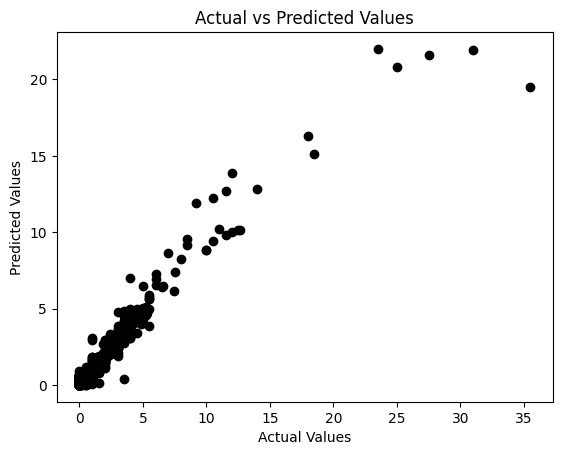

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_test_x and final_test_y are your test data
y_pred = rf_model.predict(final_test_x)

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

In [20]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importances
coeff = pd.DataFrame(list(zip(final_train_x.columns, feature_importances)), columns=['Feature', 'Importance'])
coeff.sort_values('Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(coeff)

                        Feature  Importance
1                    Time Delta    0.714215
3                 Average Power    0.133594
15          Activity_is_takeoff    0.069870
8            Activity_is_cruise    0.029216
7             Activity_is_climb    0.024855
4                   temperature    0.010241
0                    Unnamed: 0    0.008287
2                           SOH    0.003844
6                    Wind Speed    0.003187
10          Activity_is_landing    0.001163
5                    Visibility    0.001005
9           Activity_is_descent    0.000198
13      Activity_is_slow flight    0.000131
11  Activity_is_power off stall    0.000131
14      Activity_is_steep turns    0.000062
12   Activity_is_power on stall    0.000003
